<a href="https://colab.research.google.com/github/ShawnLiu119/NLP_Bank_Complaint_Classification/blob/main/CustomerComplaint_Classification_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Classification - Customer Complaints with LLM**

Purpose: explore the effectiveness of LLMs in classifying customer complaints and compare with traditional ML apporach

1. data source - https://www.kaggle.com/datasets/venkatasubramanian/automatic-ticket-classification


### Background Knowledage
Reference:https://towardsdatascience.com/fine-tune-smaller-transformer-models-text-classification-77cbbd3bf02b

A **decoder model** takes in a smaller input and outputs a larger text. GPT, which introduced impressive text generation back when, is a decoder model.

While larger language models offer more nuanced capabilities today, decoders were not built for tasks that involve extraction and labeling. For these tasks, we can use **encoder models**, which take in more input and provide a condensed output.

User Case for Encoder model:<br>
sentiment analysis, categorization, named entity recognition, and keyword extraction, among others.

**Encode Model Derivated Version History**
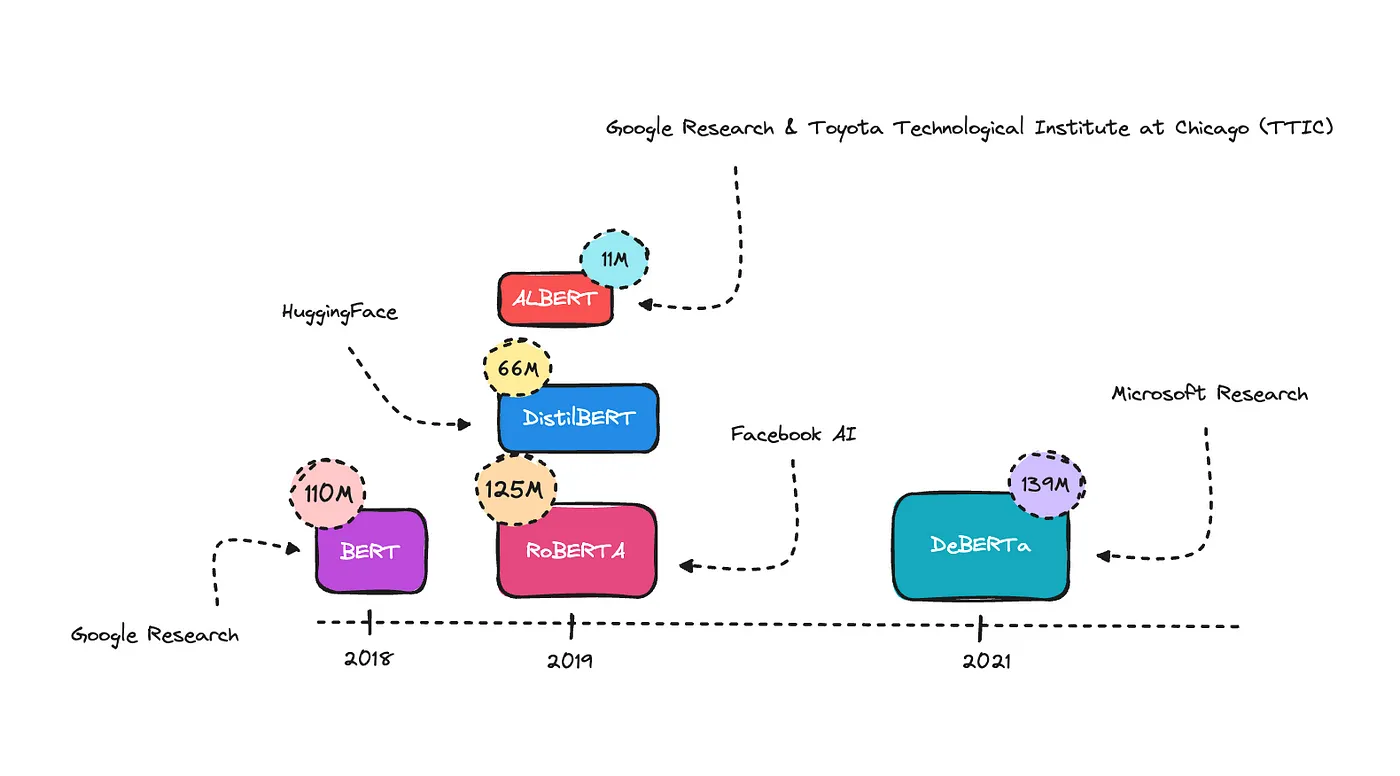


**Approach** <br>

**Fine-Tune LLM**reference：paper “How to Fine-Tune BERT for Text Classification?”

Basically, the fewer classes/labells for classification, the higher chance to get a good performance(accuracy), depedent on the complexity of dataset <br>
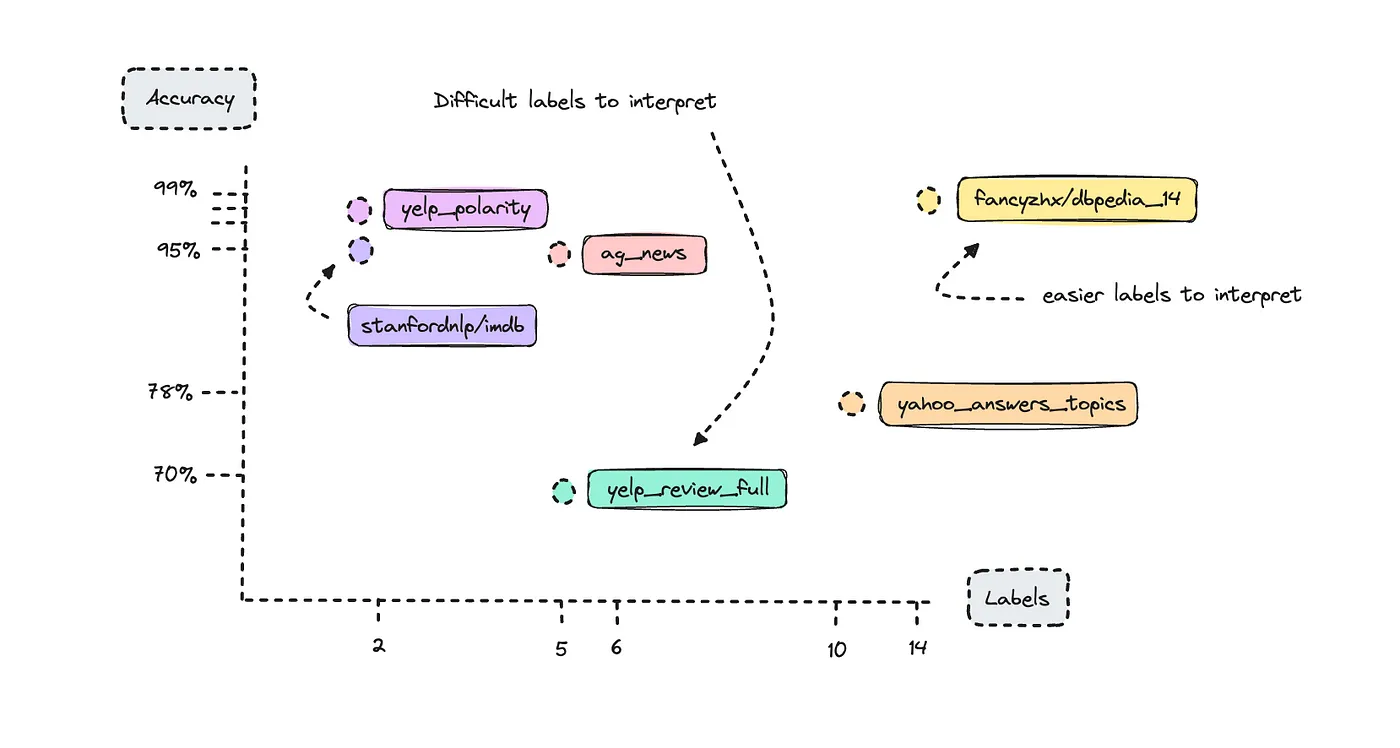

### Rationale to fine-tune your own model and host instead of using API call from AI providers(ChatGPT)
### **redundant tasks**, **large amount of data** where you **need consistency**, fine-tune can make the model more specialized for this task than API call (more general purpose)

In [ ]:
pip install datasets

In [ ]:
import json #data format
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
import os

nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
#load dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder = "/content/drive/MyDrive/kaggle_data/complaints"
file = "complaints_process_label.csv"

path = os.path.join(folder, file)

df = pd.read_csv(path)
df.head()

,Unnamed: 0.1,Unnamed: 0,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic,Topic_name
0,0,1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,4,Others
1,1,2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1,Credit card or prepaid card
2,2,10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1,Credit card or prepaid card
3,3,11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1,Credit card or prepaid card
4,4,14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0,Bank Account services


In [ ]:
data = df[['complaint_what_happened', 'Topic_name']]

In [ ]:
data.shape

(21066, 2)

In [ ]:
from sklearn.model_selection import train_test_split

# (optional) filter out any null values before creating the test, validation and training set
# df = df[df['column_name'].notnull()]

# Split dataset into training and temp (for validation and testing) - set at 15% (7.5% each)
train_df, test_df = train_test_split(data, test_size=0.25, random_state=42)


In [ ]:
import datasets
from datasets import Dataset, DatasetDict

# setup your sets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:

# create a dict dataset
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# look at the set
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['complaint_what_happened', 'Topic_name', '__index_level_0__'],
        num_rows: 15799
    })
    test: Dataset({
        features: ['complaint_what_happened', 'Topic_name', '__index_level_0__'],
        num_rows: 5267
    })
})

In [ ]:
# login - remember to get your token from the Hugging Face hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [ ]:

# push the data to hugging face
dataset_dict.push_to_hub("Shawn-Liu/complaints-dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/480 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Shawn-Liu/complaints-dataset/commit/ef445266030792543504bcf8f2e41b9661c80883', commit_message='Upload dataset', commit_description='', oid='ef445266030792543504bcf8f2e41b9661c80883', pr_url=None, pr_revision=None, pr_num=None)

###Load dataset from hugging face

In [ ]:
!pip install -U datasets
!pip install -U accelerate
!pip install -U transformers
!pip install -U huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from datasets import load_dataset, DatasetDict

dataset = load_dataset("Shawn-Liu/complaints-dataset")
dataset

Generating train split:   0%|          | 0/15799 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5267 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['complaint_what_happened', 'Topic_name', '__index_level_0__'],
        num_rows: 15799
    })
    test: Dataset({
        features: ['complaint_what_happened', 'Topic_name', '__index_level_0__'],
        num_rows: 5267
    })
})

In [ ]:
from collections import Counter

train_label_distribution = Counter(dataset['train']['Topic_name'])
test_label_distribution = Counter(dataset['test']['Topic_name'])

print("Training Label Distribution:", train_label_distribution)
print("Test Label Distribution:", test_label_distribution)

Training Label Distribution: Counter({'Bank Account services': 3890, 'Credit card or prepaid card': 3746, 'Theft/Dispute Reporting': 3584, 'Others': 2873, 'Mortgage/Loan': 1706})
Test Label Distribution: Counter({'Bank Account services': 1281, 'Credit card or prepaid card': 1262, 'Theft/Dispute Reporting': 1227, 'Others': 940, 'Mortgage/Loan': 557})


In [ ]:
type(dataset)

datasets.dataset_dict.DatasetDict

The distribution of train and test dataset look pretty similar

In [ ]:
#Prepare the dataset - convert label into integer

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(dataset['train']['Topic_name'])

def encode_labels(df):
    return {'encoded_label': label_encoder.transform([df['Topic_name']])[0]}

for split in dataset:
    dataset[split] = dataset[split].map(encode_labels, batched=False)


Map:   0%|          | 0/15799 [00:00<?, ? examples/s]

Map:   0%|          | 0/5267 [00:00<?, ? examples/s]

In [ ]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

In [ ]:
#take a look at the encoded dataset
df_train = dataset['train'].to_pandas() #convert a huggingface dataset to a panda dataframe
df_train.head()

,complaint_what_happened,Topic_name,__index_level_0__,encoded_label
0,this complaint is related to a previously file...,Mortgage/Loan,5601,2
1,i have a chase xxxx xxxx card that i obtained ...,Theft/Dispute Reporting,2087,4
2,just received notice attached that chase is ...,Credit card or prepaid card,13287,1
3,on xxxxxxxx i purchase from a company called x...,Theft/Dispute Reporting,13922,4
4,ordered a product from what i thought was a re...,Theft/Dispute Reporting,14684,4


The id2label and label2id mappings in AutoConfig are used to inform the model of the specific label-to-ID mappings so we can get the actual label names rather than the numerical reps when we do inference with the model.

Due to the parametric reduction techniques used in the **ALBERT** architecture, ALBERT models have smaller parameter sizes when compared to the corresponding BERT models.

### Data Preprocessing

In [ ]:
#decide to use albert as smaller model size
model_name = "albert/albert-base-v2"
your_path = '/content/drive/MyDrive/kaggle_data/complaints'

In [ ]:
from transformers import AutoConfig

unique_labels = sorted(list(set(dataset['train']['Topic_name'])))
id2label = {i: label for i, label in enumerate(unique_labels)}
label2id = {label: i for i, label in enumerate(unique_labels)}

#load pretrained config and replace the id2label map with finetuned data
config = AutoConfig.from_pretrained(model_name)
config.id2label = id2label #customized id2label config within the pretrained config object
config.label2id = label2id

# Verify the correct labels
print("ID to Label Mapping:", config.id2label)
print("Label to ID Mapping:", config.label2id)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

ID to Label Mapping: {0: 'Bank Account services', 1: 'Credit card or prepaid card', 2: 'Mortgage/Loan', 3: 'Others', 4: 'Theft/Dispute Reporting'}
Label to ID Mapping: {'Bank Account services': 0, 'Credit card or prepaid card': 1, 'Mortgage/Loan': 2, 'Others': 3, 'Theft/Dispute Reporting': 4}


PretrainedConfig that will be loaded from pretrained transformer model <br>
https://huggingface.co/docs/transformers/en/main_classes/configuration


Parameters for fine-tuning tasks<br>
id2label (Dict[int, str], optional) — A map from index (for instance prediction index, or target index) to label.<br>
label2id (Dict[str, int], optional) — A map from label to index for the model.

In [ ]:
#loading tokenizer and model from HuggingFace
#other options: AutoTokenizer and AutoModelForSequenceClassification

from transformers import AlbertForSequenceClassification, AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, config=config)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**dataset.filter() and dataset.select()** are two method to filter data from HuggingFace dataset library

In [ ]:
def filter_invalid_content(df):
    return isinstance(df['complaint_what_happened'], str)

dataset = dataset.filter(filter_invalid_content, batched=False) #return boolean value, only retain the complaints data that is textual strings

def encode_data(batch):
    tokenized_inputs = tokenizer(batch["complaint_what_happened"], padding=True, truncation=True, max_length=256) #you can directly feed complaints text into tokenizer of the transformer model without doing preprocessing such as lower(). removing stop words
    tokenized_inputs["labels"] = batch["encoded_label"] #number
    return tokenized_inputs

dataset_encoded = dataset.map(encode_data, batched=True)
dataset_encoded

Filter:   0%|          | 0/15799 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5267 [00:00<?, ? examples/s]

Map:   0%|          | 0/15799 [00:00<?, ? examples/s]

Map:   0%|          | 0/5267 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['complaint_what_happened', 'Topic_name', '__index_level_0__', 'encoded_label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 15799
    })
    test: Dataset({
        features: ['complaint_what_happened', 'Topic_name', '__index_level_0__', 'encoded_label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5267
    })
})

**so tokenizer() generate 3 columns as input, and labels(must to use this as column name) as target variable**

**input_id**:<br> this is actually the embedding part which convert the text token sequence into number sequence based on tokenizer. for example<br>

```
txt = 'merhaba size hatta merhabalar size'
tokense = tokenizer(txt)['input_ids']
    ==>[0, 1353, 224, 16616, 9361, 224, 2]
```




**token_type_ids**: <br>self added split between sentences as different sequence, so model understand the sequence 1 (sentence) ends
https://huggingface.co/transformers/v3.2.0/glossary.html#:~:text=Token%20Type%20IDs,-Some%20models'%20purpose&text=This%20is%20enough%20for%20some,of%20sequence%20in%20the%20model.

**attention_mask**:<br>The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value.


In [ ]:
# >>> from transformers import BertTokenizer
# >>> tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
# >>> sequence_a = "HuggingFace is based in NYC"
# >>> sequence_b = "Where is HuggingFace based?"

# >>> encoded_dict = tokenizer(sequence_a, sequence_b)
# >>> decoded = tokenizer.decode(encoded_dict["input_ids"])
# which will return:

# >>> print(decoded)
# [CLS] HuggingFace is based in NYC [SEP] Where is HuggingFace based? [SEP]

dataset.map(function), the function can be applied into the items(dataframes) in the dataset dictionary

In [ ]:
dataset_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
#n general, NumPy arrays and PyTorch tensors offer similar performance for most operations.
#However, PyTorch tensors may have some advantages in some cases like the deep learning tasks.
#This is due to optimizations for GPU acceleration and automatic differentiation

The DataCollatorWithPadding ensures that all input sequences in a batch are padded to the same length, using the padding logic defined by the tokenizer.

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

**Data collators** are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of train_dataset or eval_dataset.

Next we'll set up LabelEncoder to encode labels and defines a function to compute per-label accuracy from a confusion matrix, providing label-specific accuracy metrics. I.e. when we train the model we want to see the accuracy metrics per label as well as the average metrics. This is more relevant if you have more than two labels, and one is underperforming.

### Evaluate Metrics

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import numpy as np

label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)

def per_label_accuracy(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    correct_predictions = cm.diagonal()
    label_totals = cm.sum(axis=1)
    per_label_acc = np.divide(correct_predictions, label_totals, out=np.zeros_like(correct_predictions, dtype=float), where=label_totals != 0)
    return dict(zip(labels, per_label_acc))

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    decoded_labels = label_encoder.inverse_transform(labels)
    decoded_preds = label_encoder.inverse_transform(preds)

    precision = precision_score(decoded_labels, decoded_preds, average='weighted')
    recall = recall_score(decoded_labels, decoded_preds, average='weighted')
    f1 = f1_score(decoded_labels, decoded_preds, average='weighted')
    acc = accuracy_score(decoded_labels, decoded_preds)

    labels_list = list(label_encoder.classes_)
    per_label_acc = per_label_accuracy(decoded_labels, decoded_preds, labels_list)

    per_label_acc_metrics = {}
    for label, accuracy in per_label_acc.items():
        label_key = f"accuracy_label_{label}"
        per_label_acc_metrics[label_key] = accuracy

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        **per_label_acc_metrics #per label
    }

### Model Training

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=your_path,
    num_train_epochs=3,
    warmup_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=100,
    learning_rate=2e-5, #default 5e-5
    save_steps=1000,
    gradient_accumulation_steps=2
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



The **Trainer** class provides an API for feature-complete training in PyTorch (Application Programming Interface)

**logging_steps** (int or float, optional, defaults to 500) — Number of update steps between two logs if

**weight_decay** (float, optional, defaults to 0) — The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.

**eval_steps** Number of update steps between two evaluations if eval_strategy="steps"

In [ ]:
#training model
trainer = Trainer(
    model=model,#model preloaded
    args=training_args, #parameters
    train_dataset=dataset_encoded['train'],
    eval_dataset=dataset_encoded['test'],
    compute_metrics=compute_metrics, #self define evaluation function
    tokenizer=tokenizer,
    data_collator=data_collator,#padding to same length
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Accuracy Label Bank account services,Accuracy Label Credit card or prepaid card,Accuracy Label Mortgage/loan,Accuracy Label Others,Accuracy Label Theft/dispute reporting
100,1.502900,1.530194,0.313461,0.242525,0.365560,0.313461,0.781421,0.381933,0.000000,0.070213,0.083130
200,0.815500,0.760484,0.782609,0.780353,0.789471,0.782609,0.800937,0.914422,0.779174,0.820213,0.600652
300,0.585200,0.540350,0.817543,0.818683,0.845262,0.817543,0.655738,0.853407,0.777379,0.891489,0.911165
400,0.481500,0.393250,0.867097,0.867306,0.871601,0.867097,0.886807,0.908082,0.928187,0.834043,0.801956
500,0.301400,0.374168,0.867477,0.865194,0.871733,0.867477,0.908665,0.908082,0.621185,0.912766,0.859821


In [ ]:
trainer.evaluate()
trainer.save_model(your_path)
trainer.save_state()

In [ ]:
#test with some example
from transformers import pipeline
pipe = pipeline('text-classification', model='classify-clickbait')

In [ ]:

example_titles = [
    "The Controversial Truth about Tech Debt",
    "A Comprehensive Guide for Getting Started with Hugging Face",
    "OpenAI GPT-4o: The New Best AI Model in the World. Like in the Movies. For Free",
    "GPT4 Omni — So much more than just a voice assistant",
    "Building Vector Databases with FastAPI and ChromaDB",
    "How Pieter Levels Makes (At Least) $210K a Month From His Laptop — With Zero Employees",
    "Which Is Better: Teachers or AI in the Classroom?",
    "How to Build Enterprise-Scale Generative AI Agents with AWS Bedrock: A Comprehensive Guide",
    "The Best Way To Start Your One-Person Business",
]

for title in example_titles:
    result = pipe(title)
    print(f"Title: {title}")
    print(f"Output: {result[0]['label']}")

In [ ]:
!huggingface-cli login

In [ ]:
#Push the model with your new name for it. It usually just takes the name you set when you trained it so whatever you put here doesn't matter.
tokenizer.push_to_hub("Shawn-Liu/complaints-dataset")
trainer.push_to_hub("Shawn-Liu/complaints-dataset")